In [370]:
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import pickle
import json
from database.comet import Comet
from processor.processor import Processor as p
from time import sleep
import matplotlib.pyplot as plt
import math

In [2]:
comet = Comet()

In [205]:
start = datetime(2021,5,10)
end = datetime(2022,1,1)

In [280]:
market.dropna()

crypto,date,ada,avax,btc,cake,doge,dot,eth,ltc,luna,shib,xrp,xtz
755,2021-05-10,1.6423,34.652,55816.14,35.982,0.45074,36.488,3945.88,358.89,15.850,0.000035,1.3906,6.1917
756,2021-05-11,1.7632,36.800,56670.02,36.814,0.49326,38.637,4173.45,377.60,16.310,0.000030,1.4786,7.1247
757,2021-05-12,1.5694,32.800,49631.32,29.303,0.39160,35.128,3823.21,310.40,14.619,0.000018,1.2691,5.9392
758,2021-05-13,1.9296,35.075,49670.97,29.566,0.48945,39.988,3717.91,317.95,15.911,0.000021,1.3640,6.1252
759,2021-05-14,2.0069,36.999,49841.45,31.638,0.55971,47.979,4075.01,326.23,16.403,0.000018,1.4000,6.4737
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-01-05,1.2300,97.420,43451.13,11.280,0.15900,26.720,3540.63,135.40,78.470,0.000030,0.7726,4.5090
996,2022-01-06,1.2800,95.110,43082.31,11.080,0.15990,26.720,3406.81,135.90,78.410,0.000031,0.7791,4.4520
997,2022-01-07,1.2100,86.740,41566.48,10.440,0.15500,24.900,3199.24,131.40,68.800,0.000029,0.7634,4.2530
998,2022-01-08,1.1810,83.900,41679.74,10.220,0.15090,23.990,3080.95,129.40,66.960,0.000028,0.7452,4.0050


In [215]:
apis = ["tiingo","alpha"]
retrack_days = [1,3,7,14]
signals = range(0,15,5)
reqs = range(5,35,5)
trades = []
for api in apis:
    comet.connect()
    prices = comet.retrieve(f"{api}_prices")
    comet.disconnect()
    symbols = [x.lower() for x in prices["crypto"].unique()]
    market = prices.pivot_table(index="date",columns="crypto",values="close").reset_index()
    market = p.column_date_processing(market)
    market = market.fillna(method="ffill")
    start = datetime(2021,5,10)
    end = datetime(2022,1,1)
    for symbol in tqdm(symbols):
        try:
            for rt in tqdm(retrack_days):
                for s in tqdm(signals):
                    for r in reqs:
                        signal = float(s/100)
                        req = float(r/100)
                        date = start
                        tracker = market.iloc[0][symbol].item()
                        while date < end:
                            try:
                                initial = tracker
                                futures = market[market["date"]>date]
                                futures["signal"] = (futures[symbol] - initial) / initial
                                futures.sort_values("date",inplace=True)
                                entries = futures[(futures["signal"] <= -signal) & (futures["date"] <= date+timedelta(days=rt))]
                                if entries.index.size < 1:
                                    if (end-date).days < rt:
                                        break
                                    else:
                                        tracker = futures[(futures["date"] >= date+timedelta(days=rt))].iloc[0][symbol]
                                        date = futures[(futures["date"] >= date+timedelta(days=rt))].iloc[0]["date"]
                                else:
                                    trade = entries.iloc[0]
                                    exits = market[market["date"]>trade["date"]]
                                    bp = trade[symbol]
                                    exits["delta"] = (exits[symbol] - bp) / bp
                                    profits = exits[exits["delta"] >= req]
                                    if profits.index.size < 1:
                                        breakeven = exits[exits["delta"]>=0]
                                        if breakeven.index.size < 1:
                                            exit = exits.iloc[-1]
                                            trade["sell_price"] = exit[symbol]

                                        else:
                                            exit = breakeven.iloc[0]
                                            trade["sell_price"] = bp
                                    else:
                                        exit = profits.iloc[0]
                                        trade["sell_price"] = exit[symbol]
                                    trade["sell_date"] = exit["date"]
                                    trade["buy_price"] = bp
                                    trade["delta"] = (trade["sell_price"] - trade["buy_price"])/ trade["buy_price"]
                                    trade["signal"] = signal
                                    trade["req"] = req
                                    trade["symbol"] = symbol
                                    trade["retrack_days"] = rt
                                    trade["api"] = api
                                    trades.append(trade)
                                    tracker = exit[symbol].item()
                                    date = exit["date"] + timedelta(days=1)
                            except Exception as e:
                                print(date,str(e))
                                date = date + timedelta(days=1)
        except:
            continue

  0%|                                                                                                                                      | 0/4 [00:00<?, ?it/s]

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]C:\Users\eric\AppData\Local\Temp/ipykernel_9320/1121025726.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  futures["signal"] = (futures[symbol] - initial) / initial
C:\Users\eric\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.05it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3/4 [00:04<00:01,  1.37s/it]

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████                                                                                    | 1/3 [00:00<00:00,  3.64it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 2/3 [00:00<00:00,  3.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.64it/s]

  0%|                 

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 2/3 [00:00<00:00,  2.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.90it/s]

 25%|███████████████████████████████▌                                                                                              | 1/4 [00:01<00:04,  1.58s/it]

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████                                                                                    | 1/3 [00:00<00:00,  7.14it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 2/3 [00:00<00:00,  3.60it/s]

100%|█████████████████

 33%|██████████████████████████████████████████                                                                                    | 1/3 [00:02<00:04,  2.16s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 2/3 [00:03<00:01,  1.39s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.28s/it]

 50%|███████████████████████████████████████████████████████████████                                                               | 2/4 [00:11<00:10,  5.28s/it]

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████                                                                                    | 1/3 [00:02<00:04,  2.12s/it]

 67%|█████████████████

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████                                                                                    | 1/3 [00:02<00:04,  2.15s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 2/3 [00:02<00:01,  1.11s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3/4 [00:14<00:04,  4.19s/it]

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]

 33%|█████████████████

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3/4 [00:14<00:04,  4.18s/it]

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████                                                                                    | 1/3 [00:02<00:04,  2.04s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 2/3 [00:02<00:00,  1.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s]

  0%|                                                                                                                                      | 0/4 [00:00<?, ?it/s]

  0%|                 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s]

  0%|                                                                                                                                      | 0/4 [00:00<?, ?it/s]

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████                                                                                    | 1/3 [00:00<00:00,  5.40it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 2/3 [00:00<00:00,  2.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.55it/s]

 25%|█████████████████

  0%|                                                                                                                                      | 0/4 [00:00<?, ?it/s]

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]C:\Users\eric\AppData\Local\Temp/ipykernel_9320/1121025726.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  futures["signal"] = (futures[symbol] - initial) / initial
C:\Users\eric\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pa

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3/4 [00:03<00:01,  1.23s/it]

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████                                                                                    | 1/3 [00:00<00:00,  3.57it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 2/3 [00:00<00:00,  3.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.58it/s]

  0%|                                                                                                                                      | 0/4 [00:00<?, ?it/s]

  0%|                 

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 2/3 [00:00<00:00,  2.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.87it/s]

 25%|███████████████████████████████▌                                                                                              | 1/4 [00:01<00:04,  1.61s/it]

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████                                                                                    | 1/3 [00:00<00:00,  6.80it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 2/3 [00:00<00:00,  3.47it/s]

100%|█████████████████

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 2/3 [00:00<00:00,  4.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.17it/s]

 50%|███████████████████████████████████████████████████████████████                                                               | 2/4 [00:02<00:02,  1.17s/it]

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████                                                                                    | 1/3 [00:00<00:00,  2.90it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 2/3 [00:00<00:00,  2.93it/s]

100%|█████████████████

 33%|██████████████████████████████████████████                                                                                    | 1/3 [00:00<00:00,  2.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 2/3 [00:00<00:00,  2.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.97it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████▌                               | 3/4 [00:04<00:01,  1.32s/it]

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████                                                                                    | 1/3 [00:00<00:00,  2.92it/s]

 67%|█████████████████

  0%|                                                                                                                                      | 0/4 [00:00<?, ?it/s]

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]

 33%|██████████████████████████████████████████                                                                                    | 1/3 [00:00<00:00,  5.29it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████                                          | 2/3 [00:00<00:00,  2.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.54it/s]

 25%|███████████████████████████████▌                                                                                              | 1/4 [00:01<00:05,  1.95s/it]

  0%|                 

In [216]:
t = pd.DataFrame(trades)

In [217]:
t

crypto,date,ada,avax,btc,busd,cake,doge,dot,eth,icp,...,xtz,signal,sell_price,sell_date,buy_price,delta,req,symbol,retrack_days,api
2320,2021-05-12,1.638734,34.001144,51991.927753,0.9997,30.562,0.415576,36.764845,4047.211754,3.000000e-08,...,3.000000e-08,0.0,1.917088,2021-05-13,1.638734,0.169859,0.05,ada,1,tiingo
2325,2021-05-17,2.030510,33.645126,43533.944773,0.9997,26.807,0.487018,38.691691,3280.957444,3.000000e-08,...,3.000000e-08,0.0,2.138094,2021-08-13,2.030510,0.052984,0.05,ada,1,tiingo
2416,2021-08-16,2.071978,19.095978,45905.747586,0.9997,21.330,0.319499,24.430569,3146.637988,3.000000e-08,...,3.000000e-08,0.0,2.441042,2021-08-19,2.071978,0.178121,0.05,ada,1,tiingo
2421,2021-08-21,2.435018,43.759278,48832.113099,0.9993,23.623,0.316835,27.865822,3224.280433,3.000000e-08,...,3.000000e-08,0.0,2.706354,2021-08-22,2.435018,0.111431,0.05,ada,1,tiingo
2426,2021-08-26,2.528656,41.345892,46839.594131,0.9997,24.830,0.268402,23.922038,3093.083578,3.000000e-08,...,3.000000e-08,0.0,2.946275,2021-08-27,2.528656,0.165154,0.05,ada,1,tiingo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,2021-11-24,1.666000,115.240000,57138.290000,NaN,13.960,0.217000,38.280000,4269.360000,NaN,...,4.889000e+00,0.1,38.280000,2021-11-25,38.280000,0.000000,0.30,dot,14,alpha
956,2021-11-27,1.543000,113.520000,54721.030000,NaN,13.120,0.204900,35.160000,4095.290000,NaN,...,4.618000e+00,0.1,35.160000,2021-11-28,35.160000,0.000000,0.30,dot,14,alpha
963,2021-12-04,1.420000,93.050000,49152.470000,NaN,11.590,0.178100,29.380000,4117.250000,NaN,...,4.134000e+00,0.1,29.380000,2021-12-07,29.380000,0.000000,0.30,dot,14,alpha
968,2021-12-09,1.289000,85.460000,47545.590000,NaN,11.420,0.169100,26.900000,4105.640000,NaN,...,4.840000e+00,0.1,26.900000,2021-12-11,26.900000,0.000000,0.30,dot,14,alpha


In [218]:
analysis = []
for api in apis:
    for symbol in tqdm(symbols):
        for rt in retrack_days:
            for s in tqdm(signals):
                for r in reqs:
                    try:
                        signal = float(s/100)
                        req = float(r/100)
                        iteration_trades = t[(t["symbol"] == symbol) & (t["signal"]==signal) & (t["req"]==req) & (t["retrack_days"]==rt) & (t["api"]==api)]
                        initial = 100
                        for delta in iteration_trades["delta"]:
                             initial = initial * (1+delta)
                        iteration_trades["hpr"] = iteration_trades["sell_date"] - iteration_trades["date"]
                        iteration_trades["days"] = [x.days for x in iteration_trades["hpr"]]
                        days = iteration_trades["days"].mean()
                        analysis.append({"symbol":symbol,"signal":signal,"req":req,"trades":iteration_trades.index.size,"pv":initial,"days":days,"retrack_days":rt,"api":api})
                    except Exception as e:
                        print(str(e))

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]C:\Users\eric\AppData\Local\Temp/ipykernel_9320/3129682286.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iteration_trades["hpr"] = iteration_trades["sell_date"] - iteration_trades["date"]
C:\Users\eric\AppData\Local\Temp/ipykernel_9320/3129682286.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iteration_trades["days"] = [x.days for x in 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 40.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.09it/s]

100%|█████████████████

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 40.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 39.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 39.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 40.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 40.53it/s]

100%|█████████████████

In [219]:
a = pd.DataFrame(analysis)
a.sort_values("pv",ascending=False).head(50)

,symbol,signal,req,trades,pv,days,retrack_days,api
1499,luna,0.00,0.30,10,1525.592372,17.900000,14,alpha
1498,luna,0.00,0.25,9,1288.166048,19.444444,14,alpha
1510,luna,0.10,0.25,9,1264.830071,15.222222,14,alpha
1509,luna,0.10,0.20,10,1108.166425,12.700000,14,alpha
1511,luna,0.10,0.30,7,1010.932103,20.000000,14,alpha
1504,luna,0.05,0.25,8,939.047403,18.500000,14,alpha
1505,luna,0.05,0.30,7,887.789332,21.714286,14,alpha
1577,avax,0.05,0.30,10,872.351865,16.300000,14,alpha
713,avax,0.05,0.30,9,863.120065,18.555556,14,tiingo
1559,avax,0.05,0.30,10,809.752480,17.300000,7,alpha


In [220]:
best_iterations = []
for api in apis:
    for symbol in symbols:
        try:
            current = a[(a["api"]==api) & (a["symbol"]==symbol)].sort_values("pv",ascending=False).iloc[0]
            best_iterations.append(current)
        except:
            continue
performance = pd.DataFrame(best_iterations)
performance.sort_values("pv",ascending=False)

,symbol,signal,req,trades,pv,days,retrack_days,api
1499,luna,0.00,0.30,10,1525.592372,17.900000,14,alpha
1577,avax,0.05,0.30,10,872.351865,16.300000,14,alpha
713,avax,0.05,0.30,9,863.120065,18.555556,14,tiingo
1326,xtz,0.10,0.05,17,653.876069,2.705882,3,alpha
842,dot,0.10,0.15,15,524.891999,9.200000,7,tiingo
1706,dot,0.10,0.15,15,524.866024,9.200000,7,alpha
49,ada,0.10,0.10,14,381.982286,6.500000,7,tiingo
174,cake,0.10,0.05,15,373.637414,2.533333,3,tiingo
1038,cake,0.10,0.05,14,366.652946,2.642857,3,alpha
915,ada,0.10,0.20,13,363.645617,8.000000,7,alpha


In [222]:
performance.to_csv("report.csv")

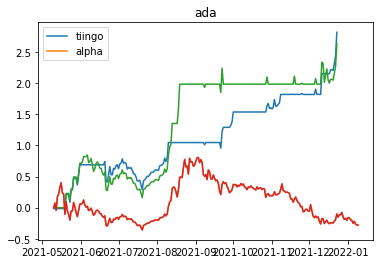

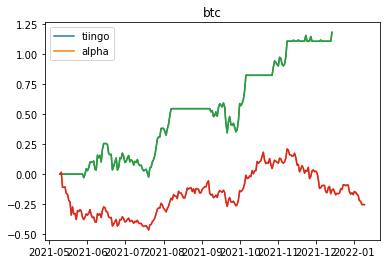

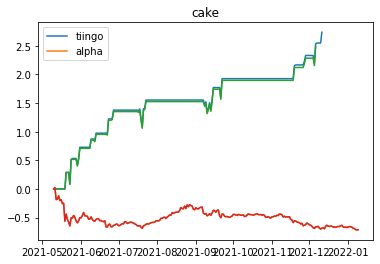

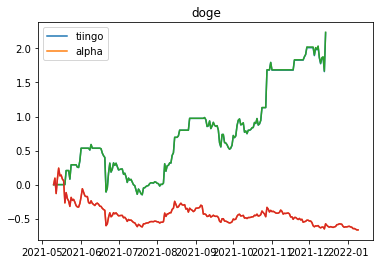

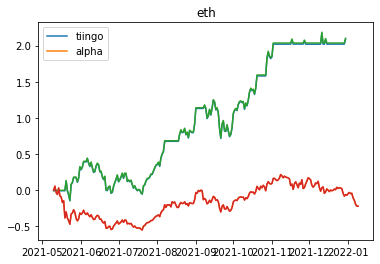

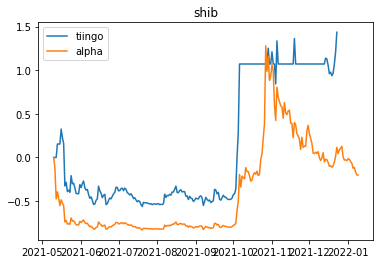

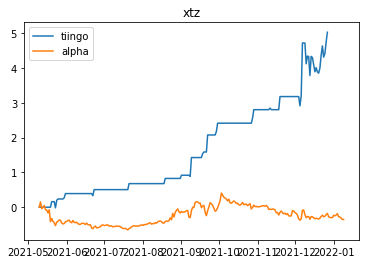

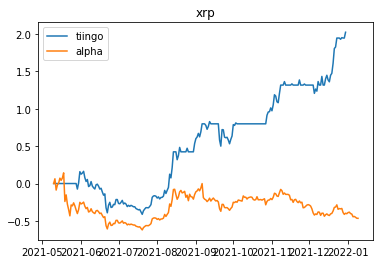

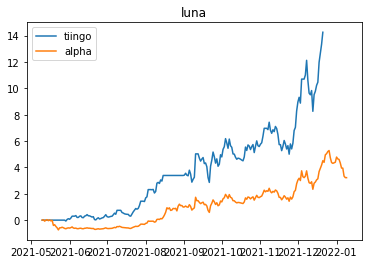

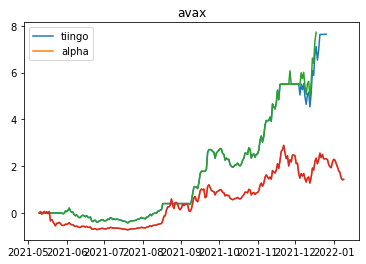

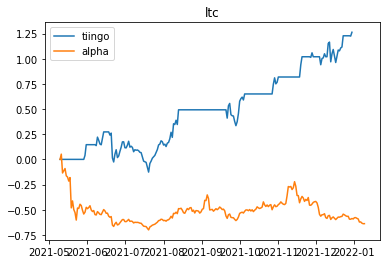

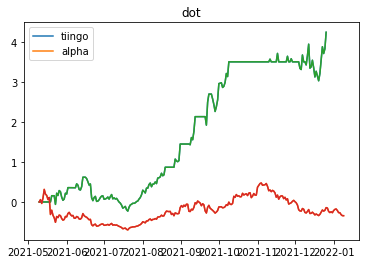

In [281]:
for symbol in performance["symbol"].unique():
    for api in ["tiingo","alpha"]:
        goods = performance[(performance["symbol"]==symbol) & (performance["api"]==api)]
        current_trades = t[(t["symbol"]==symbol) 
                           & (t["signal"]==goods["signal"].item())
                               & (t["req"]==goods["req"].item())
                                & (t["retrack_days"]==goods["retrack_days"].item())
                                  & (t["api"]==api)
                          ]
        if current_trades.index.size > 1:
            viz = []
            row = current_trades.iloc[0]
            pv = 100
            start_date = row["date"]
            amount = float(pv/row["buy_price"])
            end_date = row["sell_date"]
            pv2 = amount * row["sell_price"]
            viz.append({"date":start_date,"amount":amount})
            viz.append({"date":end_date,"amount":amount})
            track_date = start_date
            while track_date < end_date - timedelta(days=1):
                track_date = track_date + timedelta(days=1)
                viz.append({"date":track_date,"amount":amount})
            for i in range(1,current_trades.index.size-1):
                row = current_trades.iloc[i]
                prev = current_trades.iloc[i-1]
                start_date = row["date"]
                pv = pv2
                amount =  pv /row["buy_price"]
                viz.append({"date":start_date,"amount":amount})
                track_date = start_date
                end_date = row["sell_date"]
                while track_date < end_date:
                    track_date = track_date + timedelta(days=1)
                    viz.append({"date":track_date,"amount":amount})
                pv2 = amount * row["sell_price"]
                viz.append({"date":end_date,"amount":amount})
            window = pd.DataFrame(viz)
            example = market.merge(window,how="left",on="date")
            example = example[example["date"]>=start]
            example["actual"] = example["amount"] * example[symbol]
            example = example.fillna(method="bfill")
            example["actual_delta"] = (example["actual"] - 100) / 100
            example["benchmark_delta"] = (example[symbol] - example[symbol].iloc[0]) / example[symbol].iloc[0] 
            if example["actual"].max() < 10000:
                plt.plot(example["date"],example["actual_delta"])
                plt.plot(example["date"],example["benchmark_delta"])
    plt.title(symbol)
    plt.legend(["tiingo","alpha"])
    plt.show()

In [523]:
api = "alpha"
retrack_days = [1,3,7,14]
signals = range(0,15,5)
reqs = range(5,35,5)
trades = []
comet.connect()
prices = comet.retrieve(f"{api}_prices")
comet.disconnect()
symbols = [x.lower() for x in prices["crypto"].unique()]
market = prices.pivot_table(index="date",columns="crypto",values="close").reset_index()
market = p.column_date_processing(market)
market = market.fillna(method="ffill")
start = datetime(2021,1,1)
end = datetime(2022,1,1)
for value in [True,False]:
    for rt in tqdm(retrack_days):
        sim = market.melt(id_vars="date").copy()
        ns = []
        for crypto in sim["crypto"].unique():
            crypto_sim = sim[sim["crypto"]==crypto].copy()
            crypto_sim.sort_values("date",inplace=True)
            crypto_sim["signal"] = crypto_sim["value"].pct_change(rt)
            crypto_sim["velocity"] = crypto_sim["signal"].pct_change(rt)
            crypto_sim["inflection"] = crypto_sim["velocity"].pct_change(rt)
            ns.append(crypto_sim)
        final = pd.concat(ns)
        for s in tqdm(signals):
            for r in reqs:
                signal = float(s/100)
                req = float(r/100)
                date = start
                while date < end:
                    try:
                        if value:
                            offerings = final[(final["date"]==date) 
                                              & (final["signal"] <= -signal)
                                              & (final["velocity"] >= -3)
                                              & (final["velocity"] < 0)
                                               & (final["inflection"] >= -1)
                                              & (final["inflection"] <= 1)].sort_values("signal",ascending=False)
                        else:
                            offerings = final[(final["date"]==date) 
                                              & (final["signal"] >= signal)
                                             & ((final["velocity"] > 0))
                                           & ((final["inflection"] <= 1)
                                          | (final["inflection"] >= -1)
                                             )].sort_values("signal",ascending=False)
                        if offerings.index.size < 1:
                            date = date + timedelta(days=1)
                        else:
                            trade = offerings.iloc[0]
                            symbol = trade["crypto"]
                            exits = final[(final["date"]>trade["date"]) & (final["crypto"]==symbol)]
                            bp = trade["value"]
                            exits["delta"] = (exits["value"] - bp) / bp
                            profits = exits[(exits["delta"] >= req) & (exits["date"] <= trade["date"]+timedelta(days=rt))]
                            breakeven = exits[exits["delta"]>=0 & (exits["date"] > trade["date"]+timedelta(days=rt))]
                            if profits.index.size < 1:
                                if breakeven.index.size < 1:
                                    exit = exits.iloc[-1]
                                    trade["sell_price"] = exit["value"]
                                else:
                                    exit = breakeven.iloc[0]
                                    trade["sell_price"] = bp
                            else:
                                exit = profits.iloc[0]
                                trade["sell_price"] = exit["value"]
                            trade["sell_date"] = exit["date"]
                            trade["buy_price"] = bp
                            trade["delta"] = (trade["sell_price"] - trade["buy_price"])/ trade["buy_price"]
                            trade["signal"] = signal
                            trade["req"] = req
                            trade["symbol"] = symbol
                            trade["retrack_days"] = rt
                            trade["value"] = value
                            trades.append(trade)
                            date = exit["date"] + timedelta(days=1)
                    except Exception as e:
                        print(date,str(e))
                        date = date + timedelta(days=1)

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]C:\Users\eric\AppData\Local\Temp/ipykernel_9320/1956995618.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exits["delta"] = (exits["value"] - bp) / bp
C:\Users\eric\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
C:\Users\eric\AppData\Local\Programs\

In [524]:
t = pd.DataFrame(trades)

981

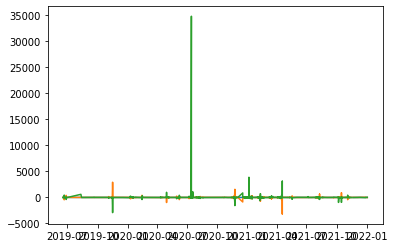

In [525]:
test = final[ (final["signal"] >= signal)
                                      & ((final["velocity"] >= 3)
                                      | (final["velocity"] <= -3))
                                       & ((final["inflection"] <= -1)
                                      | (final["inflection"] >= 1))].dropna().sort_values("date")
plt.plot(test["date"],test["signal"])
plt.plot(test["date"],test["velocity"])
plt.plot(test["date"],test["inflection"])
test.index.size

In [526]:
analysis = []
api = "alpha"
for value in [True,False]:
    for rt in retrack_days:
        for s in tqdm(signals):
            for r in reqs:
                try:
                    signal = float(s/100)
                    req = float(r/100)
                    iteration_trades = t[(t["signal"]==signal) & (t["req"]==req) & (t["retrack_days"]==rt) & (t["value"]==value)]
                    initial = 100
                    for delta in iteration_trades["delta"]:
                         initial = initial * (1+delta)
                    iteration_trades["hpr"] = iteration_trades["sell_date"] - iteration_trades["date"]
                    iteration_trades["days"] = [x.days for x in iteration_trades["hpr"]]
                    days = iteration_trades["days"].mean()
                    analysis.append({"signal":signal,"req":req,"trades":iteration_trades.index.size,"pv":initial,"days":days,"retrack_days":rt,"value":value})
                except Exception as e:
                    print(str(e))

  0%|                                                                                                                                      | 0/3 [00:00<?, ?it/s]C:\Users\eric\AppData\Local\Temp/ipykernel_9320/2774411654.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iteration_trades["hpr"] = iteration_trades["sell_date"] - iteration_trades["date"]
C:\Users\eric\AppData\Local\Temp/ipykernel_9320/2774411654.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iteration_trades["days"] = [x.days for x in 

In [527]:
a = pd.DataFrame(analysis)
a.sort_values("pv",ascending=False).head(10)

,signal,req,trades,pv,days,retrack_days,value
91,0.00,0.10,36,3617.272860,8.694444,3,False
142,0.10,0.25,21,3138.041086,16.809524,14,False
136,0.05,0.25,21,3138.041086,16.809524,14,False
130,0.00,0.25,21,3138.041086,16.809524,14,False
90,0.00,0.05,37,3018.423246,8.783784,3,False
128,0.00,0.15,30,2124.241813,11.333333,14,False
140,0.10,0.15,30,2124.241813,11.333333,14,False
134,0.05,0.15,30,2124.241813,11.333333,14,False
102,0.10,0.05,34,1914.185636,9.441176,3,False
108,0.00,0.05,32,1892.179833,10.156250,7,False


C:\Users\eric\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


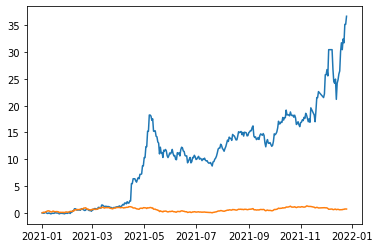

In [528]:
api = "alpha"
goods = a.sort_values("pv",ascending=False).head(10).iloc[0]
current_trades = t[(t["signal"]==goods["signal"].item())
                       & (t["req"]==goods["req"].item())
                        & (t["retrack_days"]==goods["retrack_days"].item())
                          & (t["value"]==goods["value"].item())
                  ]
current_trades.sort_values("sell_date",inplace=True)
if current_trades.index.size > 1:
    viz = []
    row = current_trades.iloc[0]
    pv = 100
    start_date = row["date"]
    symbol = row["symbol"]
    amount = float(pv/row["buy_price"])
    end_date = row["sell_date"]
    pv2 = amount * row["sell_price"]
    viz.append({"date":start_date,"crypto":symbol,"amount":amount})
    viz.append({"date":end_date,"crypto":symbol,"amount":amount})
    track_date = start_date
    while track_date < end_date - timedelta(days=1):
        track_date = track_date + timedelta(days=1)
        viz.append({"date":track_date,"crypto":symbol,"amount":amount})
    for i in range(1,current_trades.index.size-1):
        row = current_trades.iloc[i]
        symbol = current_trades.iloc[i]["symbol"]
        start_date = row["date"]
        pv = pv2
        amount =  pv /row["buy_price"]
        viz.append({"date":start_date,"crypto":symbol,"amount":amount})
        track_date = start_date
        end_date = row["sell_date"]
        while track_date < end_date:
            track_date = track_date + timedelta(days=1)
            viz.append({"date":track_date,"crypto":symbol,"amount":amount})
        pv2 = amount * row["sell_price"]
        viz.append({"date":end_date,"crypto":symbol,"amount":amount})
    window = pd.DataFrame(viz)
    example = final.merge(window,how="left",on=["date","crypto"])
    example = example.dropna().sort_values("date")
    example["actual"] = example["amount"] * example["value"]
    example = example.merge(market[["date","btc"]],on="date",how="left")
    example["bench_delta"] = (example["btc"] - example["btc"].iloc[0]) / example["btc"].iloc[0]
    example["actual_delta"] = (example["actual"] - example["actual"].iloc[0]) / example["actual"].iloc[0]
    if example["actual"].max() < 10000:
        plt.plot(example["date"],example["actual_delta"])
        plt.plot(example["date"],example["bench_delta"])
plt.show()

In [529]:
symbol_analysis = []
for symbol in current_trades["crypto"].unique():
    symbol_trades = current_trades[current_trades["crypto"]==symbol]
    trades = symbol_trades.index.size
    initial = 1
    for delta in symbol_trades["delta"]:
        initial = initial * 1+delta
    symbol_return = initial
    symbol_trades["hpr"] = symbol_trades["sell_date"] - symbol_trades["date"]
    symbol_trades["days"] = [x.days for x in symbol_trades["hpr"]]
    symbol_analysis.append({"symbol":symbol,"return":initial,"trades":trades,"hpr":symbol_trades["days"].mean()})

C:\Users\eric\AppData\Local\Temp/ipykernel_9320/922708580.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_trades["hpr"] = symbol_trades["sell_date"] - symbol_trades["date"]
C:\Users\eric\AppData\Local\Temp/ipykernel_9320/922708580.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_trades["days"] = [x.days for x in symbol_trades["hpr"]]


In [530]:
pd.DataFrame(symbol_analysis).sort_values("return",ascending=False)

,symbol,return,trades,hpr
3,doge,3.120250,8,1.125000
2,luna,2.005048,9,5.444444
0,avax,1.571124,6,2.666667
6,cake,1.303964,6,4.500000
5,xrp,1.153558,1,1.000000
1,ada,1.000000,2,12.500000
4,ltc,1.000000,1,24.000000
7,btc,1.000000,1,160.000000
8,eth,1.000000,1,1.000000
9,shib,1.000000,1,1.000000
